<a href="https://colab.research.google.com/github/8Dis-like/UCLALearning/blob/main/CM146_week8_discussion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 72.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk.data
from collections import Counter
import matplotlib.pyplot as plt # *** NEW: For visualization ***

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train = pd.read_csv("/content/labeledTrainData.tsv.zip", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("/content/testData.tsv.zip", header=0, delimiter="\t", quoting=3)
unlabeled_train = pd.read_csv("/content/unlabeledTrainData.tsv.zip", header=0, delimiter="\t", on_bad_lines='skip', quoting=3)

def review_to_wordlist(review, remove_stopwords=False):
    review_text = BeautifulSoup(review, "html.parser").get_text()
    review_text = re.sub("[^a-zA-Z]", " ", review_text)
    words = review_text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return words

def review_to_sentences(review, tokenizer, remove_stopwords=False):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [ ]:
num_features = 300
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3
model_name = "300features_40minwords_10context"

if os.path.exists(model_name):
    word2vec_model = Word2Vec.load(model_name)
else:
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    sentences = []
    for review in train["review"]:
        sentences += review_to_sentences(review, tokenizer)
    for review in unlabeled_train["review"]:
        sentences += review_to_sentences(review, tokenizer)

    word2vec_model = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count=min_word_count, window=context, sample=downsampling)
    del sentences
    word2vec_model.save(model_name)


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
VOCAB_SIZE = 20000
MAX_LEN = 200
EMBEDDING_DIM = 300

train_reviews_words = [review_to_wordlist(review) for review in train['review']]
test_reviews_words = [review_to_wordlist(review) for review in test['review']]
word_counts = Counter(word for review in train_reviews_words for word in review)
top_words = word_counts.most_common(VOCAB_SIZE - 2)
word_to_idx = {"<pad>": 0, "<unk>": 1}
for i, (word, count) in enumerate(top_words, start=2):
    word_to_idx[word] = i
def texts_to_sequences(reviews, word_to_idx):
    return [[word_to_idx.get(word, 1) for word in review] for review in reviews]
X_train_seq = texts_to_sequences(train_reviews_words, word_to_idx)
X_test_seq = texts_to_sequences(test_reviews_words, word_to_idx)
def pad_sequences_manual(sequences, maxlen):
    padded = np.zeros((len(sequences), maxlen), dtype=int)
    for i, seq in enumerate(sequences):
        padded[i, -len(seq):] = seq[:maxlen] if len(seq) > maxlen else seq
    return padded

X_all_train = pad_sequences_manual(X_train_seq, maxlen=MAX_LEN)
y_all_train = train['sentiment'].values
X_test = pad_sequences_manual(X_test_seq, maxlen=MAX_LEN)

word_index = word_to_idx
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < VOCAB_SIZE and word in word2vec_model.wv.key_to_index:
        embedding_matrix[i] = word2vec_model.wv[word]

X_train, X_val, y_train, y_val = train_test_split(
    X_all_train, y_all_train, test_size=0.2, random_state=42, stratify=y_all_train
)

X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
embedding_matrix_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor) # New validation dataset
test_dataset = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) # New validation loader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, pretrained_weights, dropout_prob=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob) # New Dropout Layer
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        final_output = lstm_out[:, -1, :]
        dropped_out = self.dropout(final_output)
        output = self.fc(dropped_out)
        return output


HIDDEN_DIM = 128
EPOCHS = 100
LEARNING_RATE = 1e-4
DROPOUT_PROB = 0.5
PATIENCE = 10

model = LSTMClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, embedding_matrix_tensor, DROPOUT_PROB)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_model_path = 'best_model.pth'

for epoch in range(EPOCHS):
    model.train()
    total_train_loss, correct_train, total_train = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        preds = torch.sigmoid(outputs) > 0.5
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / total_train

    model.eval()
    total_val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / total_val

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
        print(f"  Validation loss decreased. Saving best model.")
    else:
        patience_counter += 1
        print(f"  Validation loss did not improve. Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

Epoch 1/100 | Train Loss: 0.6733 | Train Acc: 0.5809 | Val Loss: 0.6473 | Val Acc: 0.6386
  Validation loss decreased. Saving best model.
Epoch 2/100 | Train Loss: 0.5512 | Train Acc: 0.7268 | Val Loss: 0.5009 | Val Acc: 0.7736
  Validation loss decreased. Saving best model.
Epoch 3/100 | Train Loss: 0.4681 | Train Acc: 0.7951 | Val Loss: 0.4472 | Val Acc: 0.8090
  Validation loss decreased. Saving best model.
Epoch 4/100 | Train Loss: 0.4320 | Train Acc: 0.8175 | Val Loss: 0.4322 | Val Acc: 0.8152
  Validation loss decreased. Saving best model.
Epoch 5/100 | Train Loss: 0.4274 | Train Acc: 0.8179 | Val Loss: 0.4237 | Val Acc: 0.8180
  Validation loss decreased. Saving best model.
Epoch 6/100 | Train Loss: 0.4025 | Train Acc: 0.8343 | Val Loss: 0.4298 | Val Acc: 0.8100
  Validation loss did not improve. Patience: 1/10
Epoch 7/100 | Train Loss: 0.3953 | Train Acc: 0.8361 | Val Loss: 0.4318 | Val Acc: 0.8092
  Validation loss did not improve. Patience: 2/10
Epoch 8/100 | Train Loss: 0.37

In [ ]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds = []
with torch.no_grad():
    for (inputs,) in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs)
        all_preds.extend(preds.cpu().numpy())

predictions = np.array(all_preds)
sentiments = (predictions > 0.5).astype(int).flatten()

output = pd.DataFrame(data={"id": test["id"], "sentiment": sentiments})
output.to_csv("PyTorch_LSTM_Advanced_model.csv", index=False, quoting=3)


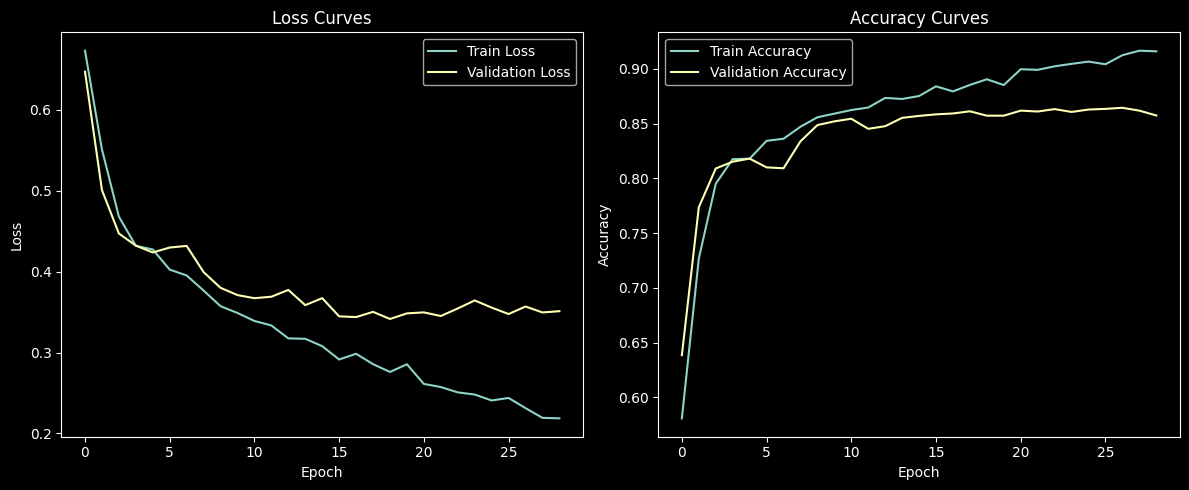

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()